In [19]:
import gymnasium as gym
import numpy as np
import math
import random
import warnings
import time
import matplotlib.pyplot as plt
from gymnasium import RewardWrapper

In [20]:
# Hacemos "resbaladizo" el entorno CliffWalking
class SlipperyCliffWalking(gym.ActionWrapper):
    def __init__(self, env, slip_probability=0.1):
        super().__init__(env)
        self.slip_probability = slip_probability

    def action(self, action):
        # Con una probabilidad 'slip_probability', ignoramos la acción elegida
        # y tomamos una aleatoria
        if random.random() < self.slip_probability:
            return self.env.action_space.sample()
        return action

In [21]:
# Crea el entorno FrozenLake indicandole los parámetros. Para empezar, que el parámetro is_slippery = False.
# Configuración del entorno (Fase Inicial de la Práctica 1)
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False) #, render_mode="human") con esto va más lento 

episodes = 2000   # Número de episodios para entrenar en cliff

In [22]:
# Cargamos el CliffWalking normal
env = gym.make("CliffWalking-v1")
env = SlipperyCliffWalking(env, slip_probability=0.1)

episodes = 15000   # Número de episodios para entrenar en cliff

In [23]:
# Hiperparámetros (Valores típicos para empezar)
alpha = 0.1       # Tasa de aprendizaje (cuánto confío en la nueva experiencia)
gamma = 0.99      # Factor de descuento (cuánto me importa el futuro)
epsilon = 1.0          # Empezamos siendo 100% exploradores
max_epsilon = 1.0      # Máximo valor de epsilon
min_epsilon = 0.01     # Mínimo valor (siempre explorará un 1%) 
decay_rate = 5/episodes     # Velocidad a la que deja de explorar

In [24]:
print("Espacio de observación\n")
print("Tamaño del espacio de observación:", env.observation_space.n)
print("Estado del espacio de observación (ejemplo):", env.observation_space.sample())

Espacio de observación

Tamaño del espacio de observación: 48
Estado del espacio de observación (ejemplo): 36


In [25]:
print("Espacio de acciones")
print("Tamaño del espacio de acciones:", env.action_space.n)
print("Acción aleatoria (ejemplo):", env.action_space.sample())

Espacio de acciones
Tamaño del espacio de acciones: 4
Acción aleatoria (ejemplo): 2


In [26]:
# Inicializar la Tabla Q (Matriz de Ceros)
n_states = env.observation_space.n
n_actions = env.action_space.n
Q_table = np.zeros((n_states, n_actions)) # Serán 16 filas (1 por casilla) x 4 columnas (1 por acción)

# Visualizamos la tabla antes del entrenamiento 
print("Tabla Q Inicial")
print(Q_table)

Tabla Q Inicial
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [27]:
def choose_action(state, q_table, epsilon, env):
    if np.random.rand() < epsilon:
        return env.action_space.sample() # Aleatorio
    else:
        return np.argmax(q_table[state]) # El mejor conocido

In [28]:
# MONTECARLO

# Elimmina un warning feo
warnings.filterwarnings("ignore", category=UserWarning, module="pygame")

# Listas para guardar métricas
rewards_history = []
max_steps_per_episode = 500  # límite de seguridad para evitar bucles infinitos

print("Entrenando con Montecarlo y Epsilon Decay...")

for i in range(episodes):

    # Mostramos los episodios cada 100 para saber por donde va 
    if i % 100 == 0:
        print("Episodio número:", i)
    
    state, info = env.reset()
    done = False
    episode_history = []

    # Contador de pasos para este episodio 
    steps = 0
    
    while not done:
        # Elegir acción
        action = choose_action(state, Q_table, epsilon, env)
        
        # Ejecutar paso
        next_state, reward, terminated, truncated, info = env.step(action)
        episode_history.append((state, action, reward))

        steps += 1
        if steps >= max_steps_per_episode:
            truncated = True # Si pasa el máximo de pasos forzamos la parada para evitar bucles infintos
        
        done = terminated or truncated
        state = next_state

    # ACTUALIZAR LA TABLA Q (solo si tenemos historia)
    if len(episode_history) > 0:
        G = 0
        for t in range(len(episode_history)-1, -1, -1):
            state, action, reward = episode_history[t]
            G = reward + gamma * G
            # Fórmula de actualización
            Q_table[state][action] = Q_table[state][action] + alpha * (G - Q_table[state][action])
            
        rewards_history.append(episode_history[-1][2])
    
    # En cada episodio, reducimos un poco la aleatoriedad reduciendo epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * i)

print("¡Entrenamiento finalizado!")

Entrenando con Montecarlo y Epsilon Decay...
Episodio número: 0
Episodio número: 100
Episodio número: 200
Episodio número: 300
Episodio número: 400
Episodio número: 500
Episodio número: 600
Episodio número: 700
Episodio número: 800
Episodio número: 900
Episodio número: 1000
Episodio número: 1100
Episodio número: 1200
Episodio número: 1300
Episodio número: 1400
Episodio número: 1500
Episodio número: 1600
Episodio número: 1700
Episodio número: 1800
Episodio número: 1900
Episodio número: 2000
Episodio número: 2100
Episodio número: 2200
Episodio número: 2300
Episodio número: 2400
Episodio número: 2500
Episodio número: 2600
Episodio número: 2700
Episodio número: 2800
Episodio número: 2900
Episodio número: 3000
Episodio número: 3100
Episodio número: 3200
Episodio número: 3300
Episodio número: 3400
Episodio número: 3500
Episodio número: 3600
Episodio número: 3700
Episodio número: 3800
Episodio número: 3900
Episodio número: 4000
Episodio número: 4100
Episodio número: 4200
Episodio número: 4300

Tabla Q aprendida:
[[  -31.17787664  -473.6502594   -100.95481921  -171.4753879 ]
 [-1120.88197131   -18.8039892    -63.58821688   -95.71589028]
 [  -46.50767229   -18.55893157  -589.15064257   -74.05265294]
 [  -53.42061593   -15.8524673    -56.72312851   -48.34536329]
 [  -70.09856084   -11.95500743   -96.63337875   -74.02629053]
 [  -54.75059806   -10.85300483   -42.89330945   -50.86927585]
 [  -39.36567834   -10.46955957   -48.92209141   -46.10704472]
 [  -31.86912549   -10.1728489    -36.3928605    -23.24226744]
 [  -21.7880104     -7.42705864   -42.95838892   -27.26591012]
 [  -17.85808438    -5.51362625   -28.03393374   -15.74591779]
 [  -42.59260506    -4.65477086   -42.87798906   -53.74148387]
 [  -34.93273017   -44.33490354    -3.43559076   -46.52289123]
 [ -205.22258096  -639.77320544   -30.40619745  -163.73854   ]
 [  -19.34509539   -56.18310906  -192.96472386  -435.74738528]
 [ -724.20138703   -95.84838216   -20.03768272  -104.62355951]
 [  -90.38171654   -19.49901261  -10

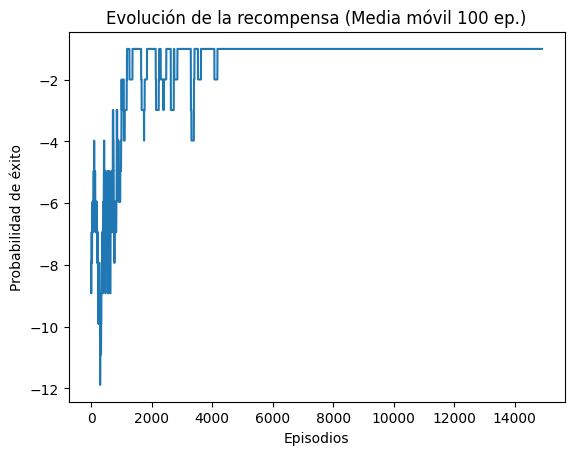

In [29]:
print("Tabla Q aprendida:")
print(Q_table)

# Visualización rápida del éxito
plt.plot(np.convolve(rewards_history, np.ones(100)/100, mode='valid'))
plt.title("Evolución de la recompensa (Media móvil 100 ep.)")
plt.xlabel("Episodios")
plt.ylabel("Probabilidad de éxito")
plt.show()

In [57]:
# Cerramos cualquier entorno zombie anterior
try:
    env_visual.close()
except:
    pass
    
# Creamos el entorno FrozenLake entrenado 
env_entrenado = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="human")

In [30]:
# Cerramos cualquier entorno zombie anterior
try:
    env_visual.close()
except:
    pass
    
# Cargamos el CliffWalking con gráficos entrenado
env_entrenado = gym.make("CliffWalking-v1", render_mode="human")
env_entrenado = SlipperyCliffWalking(env_entrenado, slip_probability=0.1)

In [31]:
state, info = env_entrenado.reset()
done = False

print("¡Mira cómo me muevo jijijijiji!")

while not done: # Hasta que no gane
    # Usamos la Q_table entrenada
    # Elegimos la acción con mejor recompensa
    action = np.argmax(Q_table[state])
    
    # Damos el paso
    state, reward, terminated, truncated, info = env_entrenado.step(action)
    env_entrenado.render()
    
    done = terminated or truncated

    # Pausamos la ejecución para verlo mas tranquilo
    time.sleep(0.5)

print("Fin de la demostración.")
env_entrenado.close()

¡Mira cómo me muevo jijijijiji!
Fin de la demostración.
